In [1]:
# Parameters
kms_key = "arn:aws:kms:us-west-2:000000000000:1234abcd-12ab-34cd-56ef-1234567890ab"


# MNIST Training with MXNet and Gluon (Testing)

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial will show how to train and test an MNIST model on SageMaker using MXNet and the Gluon API.



In [2]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name SageMakerRole to get Role path.


## Download training and test data

In [3]:
import os

for inner_dir in ["train", "test"]:
    data_dir = "./data/{}/".format(inner_dir)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

s3 = boto3.client("s3")
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-images-idx3-ubyte.gz",
    "./data/train/train-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-labels-idx1-ubyte.gz",
    "./data/train/train-labels-idx1-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-images-idx3-ubyte.gz",
    "./data/test/t10k-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-labels-idx1-ubyte.gz",
    "./data/test/t10k-labels-idx1-ubyte.gz",
)

## Uploading the data

We use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the location -- we will use this later when we start the training job.

In [4]:
inputs = sagemaker_session.upload_data(path="data", key_prefix="data/DEMO-mnist")

## Implement the training function

We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a `train` function. The `train` function will check for the validation accuracy at the end of every epoch and checkpoints the best model so far, along with the optimizer state, in the folder `/opt/ml/checkpoints` if the folder path exists, else it will skip the checkpointing. When SageMaker calls your function, it will pass in arguments that describe the training environment. Check the script below to see how this works.

The script here is an adaptation of the [Gluon MNIST example](https://github.com/apache/incubator-mxnet/blob/master/example/gluon/mnist.py) provided by the [Apache MXNet](https://mxnet.incubator.apache.org/) project. 

In [5]:
!cat 'mnist.py'

from __future__ import print_function

import argparse
import json
import logging
import os
import time

import mxnet as mx
import numpy as np
from mxnet import autograd, gluon
from mxnet.gluon import nn

logging.basicConfig(level=logging.DEBUG)

# ------------------------------------------------------------ #
# Training methods                                             #
# ------------------------------------------------------------ #


def train(args):
    # SageMaker passes num_cpus, num_gpus and other args we can use to tailor training to
    # the current container environment, but here we just use simple cpu context.
    ctx = mx.cpu()

    # retrieve the hyperparameters we set in notebook (with some defaults)
    batch_size = args.batch_size
    epochs = args.epochs
    learning_rate = args.learning_rate
    momentum = args.momentum
    log_interval = args.log_interval

    num_gpus = int(os.environ["SM_NUM_GPUS"])
    current_host = args.current_host
    hosts = args.hosts
  

## Run the training script on SageMaker

The ```MXNet``` class allows us to run our training function on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we will run our training job on a single c4.xlarge instance. 

In [6]:
m = MXNet(
    "mnist.py",
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    framework_version="1.6.0",
    py_version="py3",
    hyperparameters={
        "batch-size": 100,
        "epochs": 20,
        "learning-rate": 0.1,
        "momentum": 0.9,
        "log-interval": 100,
    },
)

After we've constructed our `MXNet` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [7]:
m.fit(inputs)

2022-03-23 07:54:40 Starting - Starting the training job.

.

.


2022-03-23 07:55:04 Starting - Preparing the instances for trainingProfilerReport-1648022080: InProgress
.

.

.

.

.

.

.

.

.


2022-03-23 07:56:37 Downloading - Downloading input data
2022-03-23 07:56:37 Training - Downloading the training image.

.

.


2022-03-23 07:57:04 Training - Training image download completed. Training in progress..

2022-03-23 07:57:04,853 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-03-23 07:57:04,856 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-23 07:57:04,877 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":100,"epochs":20,"learning-rate":0.1,"log-interval":100,"momentum":0.9}', 'SM_USER_ENTRY_POINT': 'mnist.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.c4.xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"],"instance_group_name":"homogeneousCluster","instance_type":"ml.c4.xlarge"}],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"training":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"}}', 'SM_OUTPUT_DATA_DIR': '/

[Epoch 0 Batch 300] Training: accuracy=0.881362, 3414.667188 samples/s
[Epoch 0 Batch 400] Training: accuracy=0.896010, 3732.716302 samples/s
[Epoch 0 Batch 500] Training: accuracy=0.906966, 2920.682139 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.1377900093793869,Timestamp=1648022243.8896492,IterationNumber=500)
[Epoch 0] Training: accuracy=0.915117


[Epoch 0] Validation: accuracy=0.955900
[Epoch 1 Batch 100] Training: accuracy=0.964950, 3641.552714 samples/s
[Epoch 1 Batch 200] Training: accuracy=0.965423, 4003.726613 samples/s
[Epoch 1 Batch 300] Training: accuracy=0.964086, 2954.713180 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.19525358080863953,Timestamp=1648022257.3968298,IterationNumber=1000)


[Epoch 1 Batch 400] Training: accuracy=0.964663, 3580.346229 samples/s
[Epoch 1 Batch 500] Training: accuracy=0.964890, 3408.008320 samples/s
[Epoch 1] Training: accuracy=0.965600
[Epoch 1] Validation: accuracy=0.965700


[Epoch 2 Batch 100] Training: accuracy=0.974158, 3378.035501 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0719362199306488,Timestamp=1648022271.0410192,IterationNumber=1500)
[Epoch 2 Batch 200] Training: accuracy=0.974677, 3375.724553 samples/s
[Epoch 2 Batch 300] Training: accuracy=0.974684, 4006.250597 samples/s
[Epoch 2 Batch 400] Training: accuracy=0.974539, 1842.653862 samples/s


[Epoch 2 Batch 500] Training: accuracy=0.974052, 1826.342007 samples/s
[Epoch 2] Training: accuracy=0.973933


[Epoch 2] Validation: accuracy=0.971500
[Epoch 3 Batch 100] Training: accuracy=0.983861, 3744.780544 samples/s


[Epoch 3 Batch 200] Training: accuracy=0.982090, 3856.653947 samples/s
[Epoch 3 Batch 300] Training: accuracy=0.980365, 3236.995076 samples/s


[Epoch 3 Batch 400] Training: accuracy=0.980399, 3498.898019 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.08068408071994781,Timestamp=1648022299.067164,IterationNumber=2500)
[Epoch 3 Batch 500] Training: accuracy=0.980100, 3414.417011 samples/s
[Epoch 3] Training: accuracy=0.979567
[Epoch 3] Validation: accuracy=0.970200


[Epoch 4 Batch 100] Training: accuracy=0.986040, 3101.882885 samples/s
[Epoch 4 Batch 200] Training: accuracy=0.985124, 3376.730107 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.06839568167924881,Timestamp=1648022312.537904,IterationNumber=3000)
[Epoch 4 Batch 300] Training: accuracy=0.984784, 3494.874722 samples/s
[Epoch 4 Batch 400] Training: accuracy=0.982718, 4109.403719 samples/s


[Epoch 4 Batch 500] Training: accuracy=0.982954, 3752.754863 samples/s
[Epoch 4] Training: accuracy=0.982833
[Epoch 4] Validation: accuracy=0.974800
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0037284144200384617,Timestamp=1648022326.200697,IterationNumber=3500)
[Epoch 5 Batch 100] Training: accuracy=0.986931, 4160.561843 samples/s


[Epoch 5 Batch 200] Training: accuracy=0.986617, 3676.053919 samples/s
[Epoch 5 Batch 300] Training: accuracy=0.986445, 3653.606739 samples/s
[Epoch 5 Batch 400] Training: accuracy=0.985935, 3889.052286 samples/s
[Epoch 5 Batch 500] Training: accuracy=0.985808, 2794.525951 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.011886941269040108,Timestamp=1648022339.9397879,IterationNumber=4000)


[Epoch 5] Training: accuracy=0.985417
[Epoch 5] Validation: accuracy=0.973300
[Epoch 6 Batch 100] Training: accuracy=0.988812, 3781.411661 samples/s
[Epoch 6 Batch 200] Training: accuracy=0.988308, 3706.754571 samples/s


[Epoch 6 Batch 300] Training: accuracy=0.987874, 3359.582205 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.005238096229732037,Timestamp=1648022354.1628425,IterationNumber=4500)
[Epoch 6 Batch 400] Training: accuracy=0.987157, 3352.251856 samples/s
[Epoch 6 Batch 500] Training: accuracy=0.986946, 3042.657962 samples/s
[Epoch 6] Training: accuracy=0.986233


[Epoch 6] Validation: accuracy=0.975200
[Epoch 7 Batch 100] Training: accuracy=0.990594, 3065.048267 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.026409585028886795,Timestamp=1648022367.8343725,IterationNumber=5000)
[Epoch 7 Batch 200] Training: accuracy=0.989701, 3880.704287 samples/s
[Epoch 7 Batch 300] Training: accuracy=0.989734, 4399.496518 samples/s


[Epoch 7 Batch 400] Training: accuracy=0.989476, 3178.803450 samples/s
[Epoch 7 Batch 500] Training: accuracy=0.989222, 3301.145951 samples/s


[Epoch 7] Training: accuracy=0.988650
[Epoch 7] Validation: accuracy=0.974000
[Epoch 8 Batch 100] Training: accuracy=0.991980, 3548.630653 samples/s
[Epoch 8 Batch 200] Training: accuracy=0.991045, 4172.689469 samples/s


[Epoch 8 Batch 300] Training: accuracy=0.990033, 3914.020959 samples/s
[Epoch 8 Batch 400] Training: accuracy=0.989776, 3482.599887 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.03058265894651413,Timestamp=1648022395.1215775,IterationNumber=6000)
[Epoch 8 Batch 500] Training: accuracy=0.989780, 3883.327161 samples/s
[Epoch 8] Training: accuracy=0.989767


[Epoch 8] Validation: accuracy=0.978000
[Epoch 9 Batch 100] Training: accuracy=0.993762, 2699.332617 samples/s
[Epoch 9 Batch 200] Training: accuracy=0.992637, 3815.709321 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0024082453455775976,Timestamp=1648022409.4629536,IterationNumber=6500)
[Epoch 9 Batch 300] Training: accuracy=0.991894, 3673.188717 samples/s


[Epoch 9 Batch 400] Training: accuracy=0.991845, 3907.639562 samples/s
[Epoch 9 Batch 500] Training: accuracy=0.991218, 3070.815457 samples/s
[Epoch 9] Training: accuracy=0.990683
[Epoch 9] Validation: accuracy=0.976100
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.00801093690097332,Timestamp=1648022423.0977414,IterationNumber=7000)


[Epoch 10 Batch 100] Training: accuracy=0.993663, 3864.720625 samples/s
[Epoch 10 Batch 200] Training: accuracy=0.992587, 3616.995369 samples/s
[Epoch 10 Batch 300] Training: accuracy=0.992558, 4137.006461 samples/s
[Epoch 10 Batch 400] Training: accuracy=0.991671, 3603.384909 samples/s


[Epoch 10 Batch 500] Training: accuracy=0.991058, 2821.293369 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.00041416086605750024,Timestamp=1648022437.0411632,IterationNumber=7500)
[Epoch 10] Training: accuracy=0.990483
[Epoch 10] Validation: accuracy=0.972200
[Epoch 11 Batch 100] Training: accuracy=0.993465, 3742.474994 samples/s


[Epoch 11 Batch 200] Training: accuracy=0.994279, 3327.069947 samples/s
[Epoch 11 Batch 300] Training: accuracy=0.994186, 3716.871815 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.027302701026201248,Timestamp=1648022450.6376607,IterationNumber=8000)


[Epoch 11 Batch 400] Training: accuracy=0.994015, 3788.516046 samples/s
[Epoch 11 Batch 500] Training: accuracy=0.993174, 3661.197092 samples/s
[Epoch 11] Training: accuracy=0.992983
[Epoch 11] Validation: accuracy=0.976000


[Epoch 12 Batch 100] Training: accuracy=0.994356, 3302.939671 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.009794153273105621,Timestamp=1648022464.4427505,IterationNumber=8500)
[Epoch 12 Batch 200] Training: accuracy=0.994129, 3465.221414 samples/s
[Epoch 12 Batch 300] Training: accuracy=0.994252, 3787.968607 samples/s
[Epoch 12 Batch 400] Training: accuracy=0.994214, 3853.358812 samples/s


[Epoch 12 Batch 500] Training: accuracy=0.993992, 3465.221414 samples/s
[Epoch 12] Training: accuracy=0.993600
[Epoch 12] Validation: accuracy=0.975200
[Epoch 13 Batch 100] Training: accuracy=0.993069, 4021.191697 samples/s


[Epoch 13 Batch 200] Training: accuracy=0.993184, 3533.592815 samples/s
[Epoch 13 Batch 300] Training: accuracy=0.992990, 3987.587466 samples/s
[Epoch 13 Batch 400] Training: accuracy=0.993167, 3315.812608 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.015867849811911583,Timestamp=1648022492.3159711,IterationNumber=9500)
[Epoch 13 Batch 500] Training: accuracy=0.993094, 3835.598800 samples/s


[Epoch 13] Training: accuracy=0.992783
[Epoch 13] Validation: accuracy=0.974300
[Epoch 14 Batch 100] Training: accuracy=0.995446, 3193.470382 samples/s
[Epoch 14 Batch 200] Training: accuracy=0.995174, 2992.063118 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.00028366997139528394,Timestamp=1648022506.0326982,IterationNumber=10000)


[Epoch 14 Batch 300] Training: accuracy=0.994252, 3367.296082 samples/s
[Epoch 14 Batch 400] Training: accuracy=0.992494, 3239.820486 samples/s
[Epoch 14 Batch 500] Training: accuracy=0.992575, 3722.182386 samples/s
[Epoch 14] Training: accuracy=0.992500


[Epoch 14] Validation: accuracy=0.973600
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.004581619519740343,Timestamp=1648022519.7828562,IterationNumber=10500)
[Epoch 15 Batch 100] Training: accuracy=0.995149, 3022.660383 samples/s
[Epoch 15 Batch 200] Training: accuracy=0.994279, 3828.351847 samples/s
[Epoch 15 Batch 300] Training: accuracy=0.993787, 3285.964761 samples/s


[Epoch 15 Batch 400] Training: accuracy=0.993342, 4193.633019 samples/s
[Epoch 15 Batch 500] Training: accuracy=0.993273, 2983.337482 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.060168810188770294,Timestamp=1648022534.2602084,IterationNumber=11000)
[Epoch 15] Training: accuracy=0.992850
[Epoch 15] Validation: accuracy=0.978500


[Epoch 16 Batch 100] Training: accuracy=0.993861, 4164.114172 samples/s
[Epoch 16 Batch 200] Training: accuracy=0.993383, 3074.709888 samples/s
[Epoch 16 Batch 300] Training: accuracy=0.993821, 2943.247302 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.040136903524398804,Timestamp=1648022548.0676773,IterationNumber=11500)
[Epoch 16 Batch 400] Training: accuracy=0.993392, 3901.024945 samples/s


[Epoch 16 Batch 500] Training: accuracy=0.993693, 3618.493180 samples/s
[Epoch 16] Training: accuracy=0.993650
[Epoch 16] Validation: accuracy=0.976600
[Epoch 17 Batch 100] Training: accuracy=0.994851, 3351.582177 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.006299780216068029,Timestamp=1648022561.7970061,IterationNumber=12000)


[Epoch 17 Batch 200] Training: accuracy=0.994129, 3180.780198 samples/s
[Epoch 17 Batch 300] Training: accuracy=0.994186, 3114.990828 samples/s


[Epoch 17 Batch 400] Training: accuracy=0.993990, 3512.464409 samples/s
[Epoch 17 Batch 500] Training: accuracy=0.994351, 3441.564921 samples/s
[Epoch 17] Training: accuracy=0.994283
[Epoch 17] Validation: accuracy=0.976300


[Epoch 18 Batch 100] Training: accuracy=0.994158, 3588.617191 samples/s
[Epoch 18 Batch 200] Training: accuracy=0.994478, 3818.836040 samples/s
[Epoch 18 Batch 300] Training: accuracy=0.994884, 2655.732141 samples/s
[Epoch 18 Batch 400] Training: accuracy=0.994613, 3155.438863 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.005062229465693235,Timestamp=1648022589.8933344,IterationNumber=13000)


[Epoch 18 Batch 500] Training: accuracy=0.994551, 4058.545648 samples/s
[Epoch 18] Training: accuracy=0.994583
[Epoch 18] Validation: accuracy=0.975700
[Epoch 19 Batch 100] Training: accuracy=0.993762, 3361.143700 samples/s


[Epoch 19 Batch 200] Training: accuracy=0.992637, 3635.492455 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.029170282185077667,Timestamp=1648022603.4832957,IterationNumber=13500)
[Epoch 19 Batch 300] Training: accuracy=0.992990, 3300.107006 samples/s
[Epoch 19 Batch 400] Training: accuracy=0.992843, 4220.598328 samples/s
[Epoch 19 Batch 500] Training: accuracy=0.992774, 4017.840448 samples/s


[Epoch 19] Training: accuracy=0.993233
[Epoch 19] Validation: accuracy=0.974200
2022-03-23 08:03:37,297 sagemaker-training-toolkit INFO     Reporting training SUCCESS



2022-03-23 08:03:50 Uploading - Uploading generated training model
2022-03-23 08:03:50 Completed - Training job completed


Training seconds: 459
Billable seconds: 459


After training, we use the MXNet object to build and deploy an MXNetPredictor object. This creates a SageMaker endpoint that we can use to perform inference. 

This allows us to perform inference on json encoded multi-dimensional arrays. 

In [8]:
predictor = m.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-

-

-

-

-

-

!

We can now use this predictor to classify hand-written digits. Manually drawing into the image box loads the pixel data into a 'data' variable in this notebook, which we can then pass to the MXNet predictor. 

In [9]:
from IPython.display import HTML

HTML(open("input.html").read())

Fetch the first image from the test dataset and display it.

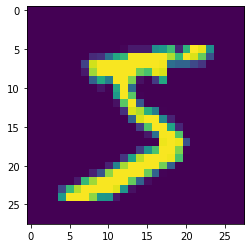

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

f = gzip.open("data/train/train-images-idx3-ubyte.gz", "r")

image_size = 28

f.read(16)
buf = f.read(image_size * image_size)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(1, image_size, image_size, 1)

image = np.asarray(data).squeeze()
plt.imshow(image)
plt.show()

The predictor runs inference on our input data and returns the predicted digit (as a float value, so we convert to int for display).

In [11]:
response = predictor.predict(data)
print(int(response))

5


## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [12]:
predictor.delete_endpoint()